# Train a VAE on Cell Painting LINCS Data

In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(8294, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [9]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [10]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=15,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=200,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0.5,
    verbose=True,
)
cp_vae.compile_vae()

In [11]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/200
260/260 [==============================] - 3s 6ms/step - loss: 37.8383 - val_loss: 12.5170
Epoch 2/200
260/260 [==============================] - 1s 4ms/step - loss: 6.2797 - val_loss: 4.9015
Epoch 3/200
260/260 [==============================] - 1s 4ms/step - loss: 4.8151 - val_loss: 4.0263
Epoch 4/200
260/260 [==============================] - 1s 4ms/step - loss: 4.1872 - val_loss: 3.8361
Epoch 5/200
260/260 [==============================] - 1s 4ms/step - loss: 3.9972 - val_loss: 3.6812
Epoch 6/200
260/260 [==============================] - 1s 3ms/step - loss: 3.9402 - val_loss: 3.7099
Epoch 7/200
260/260 [==============================] - 1s 3ms/step - loss: 3.7549 - val_loss: 3.5927
Epoch 8/200
260/260 [==============================] - 1s 4ms/step - loss: 3.8310 - val_loss: 3.5216
Epoch 9/200
260/260 [==============================] - 1s 4ms/step - loss: 3.7304 - val_loss: 3.5799
Epoch 10/200
260/260 [==============================] - 1s 4ms/step - loss: 3.6256 - val_

Epoch 161/200
260/260 [==============================] - 1s 3ms/step - loss: 2.7787 - val_loss: 2.6807
Epoch 162/200
260/260 [==============================] - 1s 4ms/step - loss: 2.7888 - val_loss: 2.7034
Epoch 163/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8275 - val_loss: 2.6704
Epoch 164/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8183 - val_loss: 2.7057
Epoch 165/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8612 - val_loss: 2.6932
Epoch 166/200
260/260 [==============================] - 1s 4ms/step - loss: 2.7702 - val_loss: 2.6958
Epoch 167/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8146 - val_loss: 2.6678
Epoch 168/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8025 - val_loss: 2.6380
Epoch 169/200
260/260 [==============================] - 1s 3ms/step - loss: 2.8591 - val_loss: 2.7305
Epoch 170/200
260/260 [==============================] - 1s 3ms/step - lo

In [12]:
cp_vae.vae

In [13]:
# cp_vae.vae.evaluate(test_features_df)

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,val_loss
0,16.546497,12.516986
1,5.761585,4.901465
2,4.575208,4.026287
3,4.178861,3.836128
4,3.956908,3.681202
...,...,...
195,2.814134,2.731535
196,2.805681,2.612085
197,2.820301,2.637290
198,2.810019,2.659426


In [15]:
history_df.to_csv('level5_training.csv')

In [3]:
# history_df = pd.read_csv('level5_training.csv')

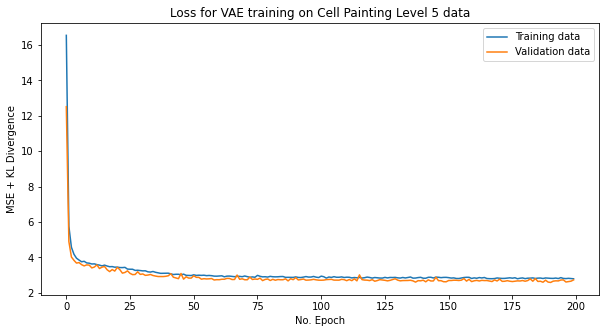

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [17]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

41.774742978182516

<AxesSubplot:>

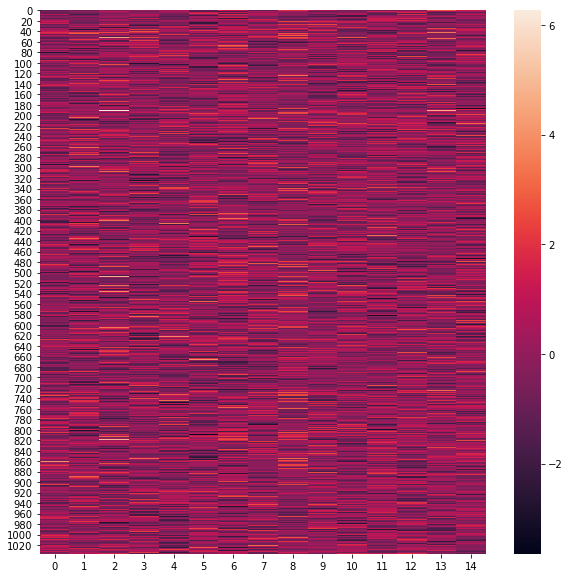

In [18]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [33]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

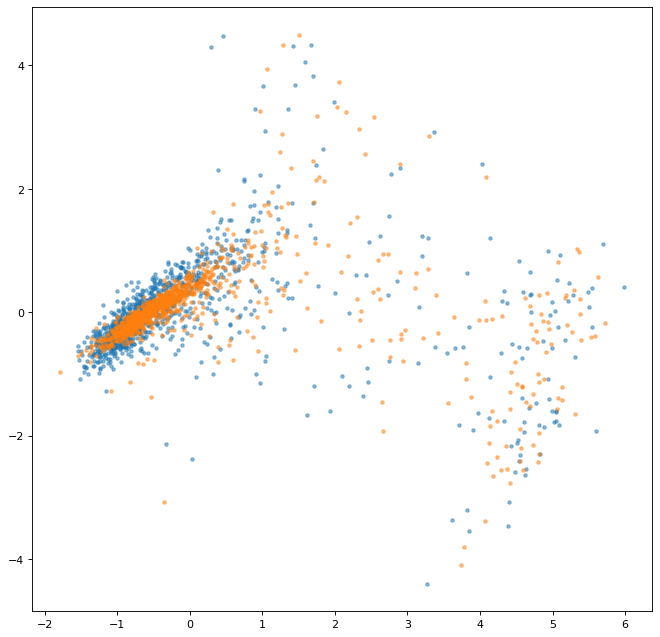

In [34]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

<AxesSubplot:>

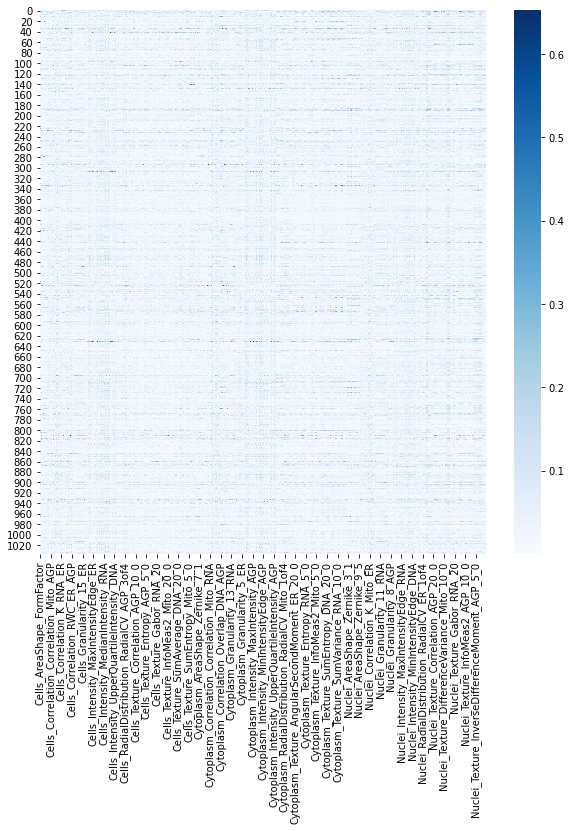

In [21]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

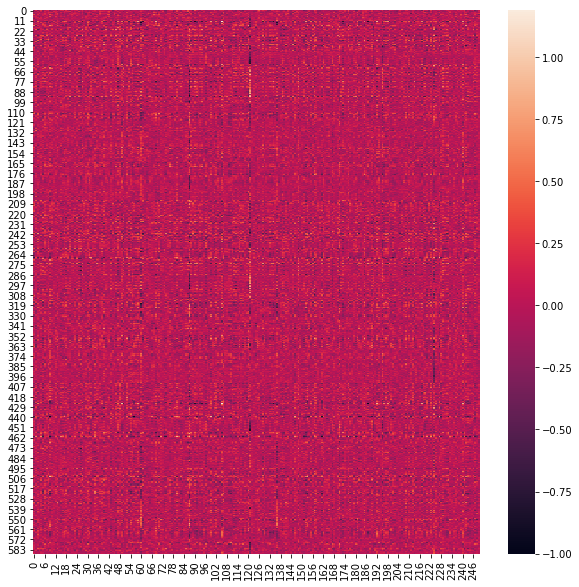

In [22]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [23]:
latent_dims = np.arange(1,51)
reconstructions = []

for latent_dim in latent_dims:
    cp_vae2 = VAE(
        input_dim=train_features_df.shape[1],
        latent_dim=latent_dim,
        batch_size=32,
        encoder_batch_norm=True,
        epochs=14,
        learning_rate=0.01,
        encoder_architecture=encoder_architecture,
        decoder_architecture=decoder_architecture,
        beta=1,
        verbose=True,
    )
    cp_vae2.compile_vae()
    cp_vae2.train(x_train=train_features_df, x_test=test_features_df)
    reconstruction = pd.DataFrame(cp_vae2.vae.predict(test_features_df), columns=cp_features)
    reconstructions.append(reconstruction)


Epoch 1/14
260/260 [==============================] - 3s 4ms/step - loss: 18.4581 - val_loss: 4.8126
Epoch 2/14
260/260 [==============================] - 1s 4ms/step - loss: 5.2000 - val_loss: 4.6676
Epoch 3/14
260/260 [==============================] - 1s 3ms/step - loss: 4.7745 - val_loss: 4.2221
Epoch 4/14
260/260 [==============================] - 1s 3ms/step - loss: 4.4154 - val_loss: 4.2551
Epoch 5/14
260/260 [==============================] - 1s 3ms/step - loss: 4.6812 - val_loss: 4.9294
Epoch 6/14
260/260 [==============================] - 1s 3ms/step - loss: 4.5152 - val_loss: 3.9213
Epoch 7/14
250/260 [===========================>..] - ETA: 0s - loss: 4.3595

KeyboardInterrupt: 

In [ ]:
frobenius_norms = []
for reconstruction in reconstructions:
    frobenius_norms.append(
        (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
    )

In [ ]:
plt.plot(frobenius_norms)
plt.xlabel("latent_dim")
plt.ylabel("Frobenius Norm")
plt.title("Cell Painting VAE")
plt.show()

In [24]:
decoder = cp_vae.decoder_block["decoder"]

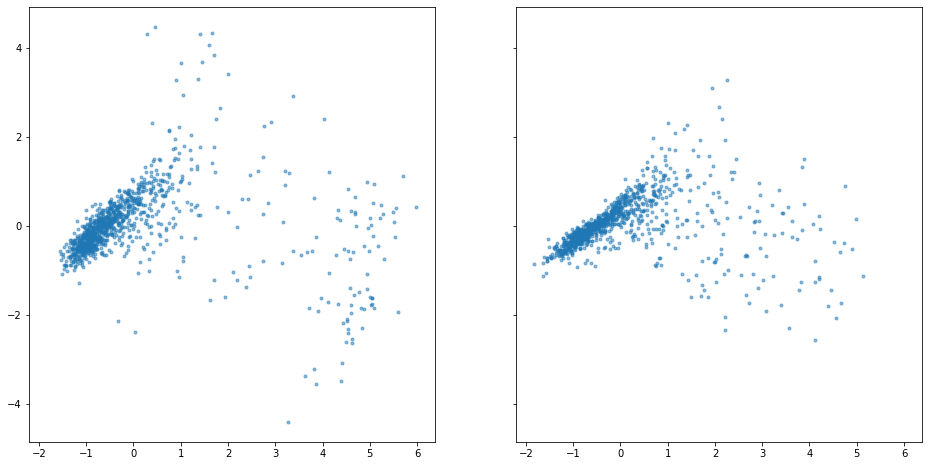

In [37]:
simulated_df = pd.DataFrame(np.random.normal(size=(1000, 15)), columns=np.arange(0,15))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca.transform(reconstruction_of_simulated))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [27]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent.csv")

In [30]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level5Decoder")

INFO:tensorflow:Assets written to: level5Decoder/assets


In [31]:
encoder.save("level5Encoder")

INFO:tensorflow:Assets written to: level5Encoder/assets
